# Image Quality Assessment with CleanX

The following notes are for users with little image processing background on what the output some functions are about.

Image quality has particular meaning for radiologists, radiographers and biomedical engineers. It assesses the quality of a radiographic image from both a technical and diagnostic perspective.

Medical imaging predominantly uses ionising radiation to obtain images that will aid a patient's diagnosis. Whilst imperative to an accurate diagnosis, image quality must balance the risk of radiation dose. The practice of using as low as possible radiation to achieve diagnostic images is known as the As Low As Reasonably Achievable (ALARA) principle. There becomes a threshold in which the pursuit of higher image quality at the cost of higher radiation to the patient becomes more harmful than good.

Nonetheless, low image quality due to technical factors such as too little radiation or incorrect protocol selection is problematic. 

As machine learning enters the realm of diagnostics, variations in image quality present new sets of problems.

This notebook's goal is to review the tools in CleanX to examine image quality "blindly". Here we use the word blindly in two senses. First, we want to be able to assess image quality blind to the characteristics of the machines that produce it (which will be set to a certain mAs and kV, and have fixed image reconstruction algorithm possibilities, and a lot of highly technical differences and settings some of which can sometimes be encoded in the DICOM metadata). We also want to be blind because we can get meaningful results when we are not comparing any image to an "ideal" image of, which is understood as a distortion or degradation. In electrical engineering lingo, this is "blind image quality assessment."

The CleanX blind_quality_matrix function was tested on images of the same phantoms shot at differing but realistic, radiation levels as measured by mAs, and differing but accurate image reconstruction algorithms. This notebook is about our specific code, not all of the technical "domain" stuff you may need to catch up on if you are from the machine learning world. For a brief non-technical, and illustrated with chest X-rays explanation about radiology image processing algorithms, look here: https://www.upstate.edu/radiology/education/rsna/processing/

In [1]:
# # We need to get the develop branch version of CleanX  2022 (sorry, I
# # just take it off my computer)

import sys
sys.path = ['D:/projects/cleanX'] + sys.path

In [2]:
# Let's get going and import our libraries:
from cleanX import (
    dataset_processing as csvp,
    dicom_processing as dicomp,
    image_work as iwork,
)

In [3]:
# Other libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import cv2

To make this notebook more accessible to people who do not usually look at X-rays, we will first look at an image that is easier to understand for everyone- a human portrait.

OK, a bit of nerd-culture history here: The Lena image (formerly nearly synonymous with image processing algorithms) left the matplotlib library. Politics, gender, progress...there is even a movie called "Losing Lena" about this issue. Suffice it to say Lena is out, and Grandma COBOL Grace Hopper is in.
 

Let's make some different version of Grandma:

In [4]:
imageG = cbook.get_sample_data('grace_hopper.jpg')
imageG = plt.imread(imageG)
blurred_1 = cv2.blur(imageG, (5,5))
blurred_2 = cv2.blur(imageG, (9,9))
light_1 =  cv2.add(imageG,np.array([150.0]))
dark_2 =  cv2.add(imageG,np.array([-150.0]))
alpha, beta = 3, 0
contrasty = cv2.convertScaleAbs(imageG, alpha=alpha, beta=beta)

cv2.imwrite('granny_cam/imageG.jpeg',imageG)
cv2.imwrite('granny_cam/blurred_1.jpeg',blurred_1)
cv2.imwrite('granny_cam/blurred_2.jpeg',blurred_2)
cv2.imwrite('granny_cam/light_1.jpeg',light_1)
cv2.imwrite('granny_cam/dark_2.jpeg',dark_2)
cv2.imwrite('granny_cam/contrasty.jpeg',contrasty)

file_names = ['granny_cam/imageG.jpeg',
              'granny_cam/blurred_1.jpeg',
              'granny_cam/blurred_2.jpeg',
              'granny_cam/light_1.jpeg',
              'granny_cam/dark_2.jpeg',
              'granny_cam/contrasty.jpeg',
             ]

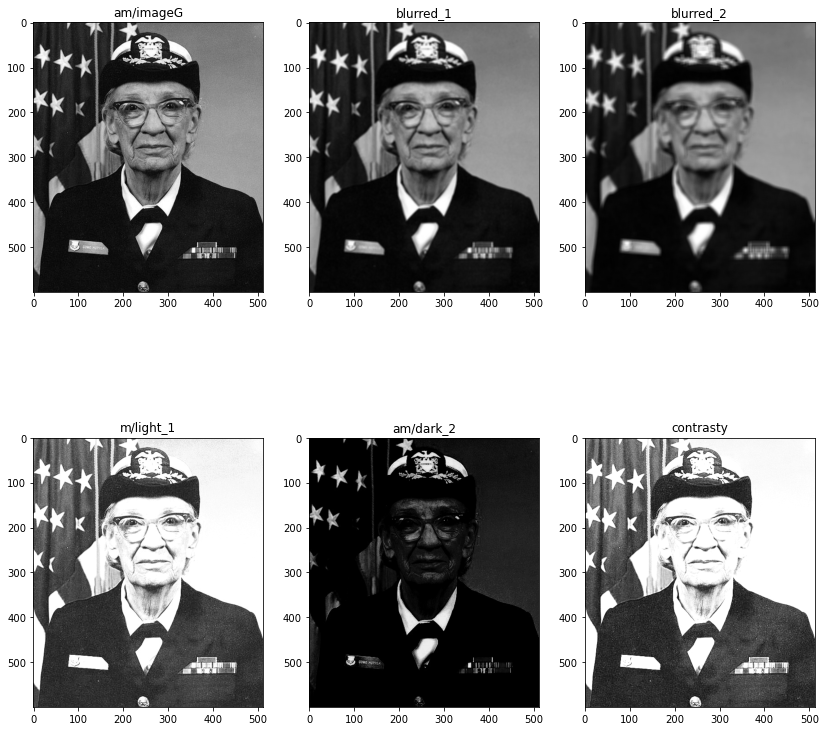

In [5]:
iwork.show_images_in_df(file_names,9)

Hopefully, within seconds, you can see that Grace got blurrier and blurrier as we increased the kernel size. Blur in medical images, e.g. motion blur, can happen for several reasons beyond the scope of this notebook...but we can all see some images are just blurrier than others. Or to say the same thing slightly differently; some images are crisper than others. How can we quantify that? We can use various equations we turn into functions.

But crispness is not the only thing we need to worry about. If you look at the lightened image, you can see it gets harder to pick out specific details compared to the original. In photographic imaging, this is analogous to under-or over-exposed images, and in radiology, we have under-or over- penetrated.
With only two qualities (penetration and crispness), we can already see that different image quality features will not necessarily correlate. Thus we can think of image quality in terms of multiple features, interpreted by various equations, which we can investigate.

If your eyes and mind are very sharp, you remix the code a little and contemplate whether there is some way of amping the contrast that improves image quality. The answer is that it's all contextual. Let's take a look at our pictures of Grace, and what the blind_quality_matrix function shows us:

In [6]:
directory1 = 'granny_cam'
iwork.blind_quality_matrix(directory1)

D:/projects/cleanX\cleanX\image_work\image_functions.py:2184: RuntimeWarning: overflow encountered in ubyte_scalars
  contrast_michaelson = (cmax-cmin)/(cmax+cmin)


,name_image,pixel_sum_over_area,laplacian_variance,fastforiertransform_crispness,file_size_over_area,contrast_std,michaelson_contrast,bit_depth
0,granny_cam\reworked.jpg,132.054083,7.637352,-44.633380,0.112647,52.807656,1.000000,8
1,granny_cam\speckled2.jpg,117.471857,9697.627986,24.430687,0.856384,62.895430,1.000000,8
2,granny_cam\blurred_1.jpeg,77.772503,35.170709,-34.389977,0.227191,64.928176,35.285713,8
3,granny_cam\blurred_2.jpeg,77.764150,9.266523,-37.668483,0.180638,62.568655,27.222221,8
4,granny_cam\contrasty.jpeg,147.492119,3275.770347,1.310295,0.429085,94.252826,1.000000,8
5,granny_cam\dark_2.jpeg,8.648249,253.454800,-33.074924,0.179183,18.973453,1.000000,8
6,granny_cam\flippy.jpeg,112.744000,6.581779,-48.254983,0.220080,61.299665,1.000000,8
7,granny_cam\flippy_lined.jpeg,108.470898,7.305622,-46.981362,0.214697,51.865272,1.000000,8
8,granny_cam\flippy_speckled.jpeg,120.592845,24305.482111,29.641506,0.915707,65.249838,1.000000,8
9,granny_cam\imageG.jpeg,77.779359,1046.264769,-10.689226,0.364118,67.950253,1.000000,8


## 1: pixel_sum_over_area
OK, we will go left to right. pixel_sum_over_area is reading in a sum of all the pixel numbers, then dividing by the area. Notice how dark_1 and dark_2 are high and low of the column? It only makes sense- dark pixels are close to zero, and light pixels are close to 255 (once we put everything on the 0-255 scale your screen works on). Therefore we can look at pixel_sum_over_area to give us some hints about over-or under-exposure or penetration. Will a chest X-ray with higher or lower pixel_sum_over_area always be differently penetrated? No. A patient with acute respiratory distress syndrome (ARDS) and dense, congested lungs will have a higher pixel_sum_over_area than one with emphysema (a condition whereby the lungs are considerably less dense). But when we group images of identical pathologies, this can indicate something when we compare the groups.   

## 2: laplacian_variance

laplacian_variance results from a mathematical formula for Laplacian variance; it is exactly what it sounds like. Variance measures the spread inside a set of numbers. In image processing, Laplacian stuff crops up in several places. For a long explanation of the Laplacian operator, Wikipedia is not bad. To cut to the chase, the Laplacian of a digital image tells us about rapid pixel value change areas. Our columns note that the contrasty image had the highest variance, and the blurriest image had the least. Just what you would expect.

## 3: fastfourier_transform crispiness

Here I will use some code to show what this is all about. The python NumPy library has several built-in ways to deal with Fourier transforms. An interesting exercise is to perform them on different image types if you have time. A Fourier transform is a very general concept often used in Physics. Usually, medical people think of them as to how MRI data are made into an image. But we can use the transform on images, the data we get out tells us (among many things)about the sharpness of the original image. Let's do a quick code example:

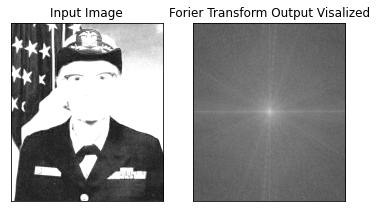

In [7]:
contrasty_ff = contrasty[:,:,0]
made_fourier = np.fft.fftshift(np.fft.fft2(contrasty_ff))
magnitude_spectrum = 20*np.log(np.abs(made_fourier))
plt.subplot(121),plt.imshow(contrasty_ff, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Forier Transform Output Visalized'), plt.xticks([]), plt.yticks([])
plt.show()

The contrasty version turned into a visualized Fourier transform. Let's see what happens when we put in our most blurred image.

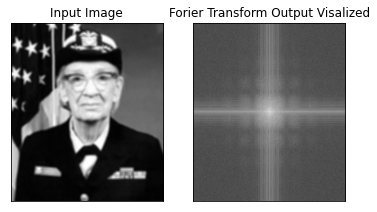

In [8]:
blurred_2_ff = blurred_2[:,:,0]
made_fourier = np.fft.fftshift(np.fft.fft2(blurred_2_ff))
magnitude_spectrum = 20*np.log(np.abs(made_fourier))
plt.subplot(121),plt.imshow(blurred_2_ff, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Forier Transform Output Visalized'), plt.xticks([]), plt.yticks([])
plt.show()

We can see the image is not the same. Encoded in the Fourier transform is information about the original images- and we can exploit that to examine many things. Our functions use the fast Fourier transform to save computing time and should be a decent surrogate for crispness in similar images. Notice the correlation with the Laplacian? Moving on...

## 4 file_size_over_area
This variable is computed by taking the file size and dividing it by the area (height*width). In our case, the areas were all the same because we made versions of the same image.

This parameter can be helpful in more similar images to tell us something about spatial resolution, but the correlation is not perfect. Nonetheless, even here, our blurred and dark images (images with less information) show a smaller number than other images. 

##  5 contrast_std 
This is pretty straightforward and intuitive. One way to measure contrast is the standard deviation of the pixel numbers.

##  6 michelson_contrast
Another way to measure contrast is through a formula of the maximum value minus the minimum divided by those two values summed.

## 7 bit_depth
This is a column that will leave many sensible people scratching their heads. Our screens are 8-bit; our eyes can see fewer gradations than that, so why worry about whether our images are 8-bit or higher? 

The answer is that some types of imaging are now routinely acquired at 16-bit depth, and it is possible digital radiographs could go this way. Even if the trend never takes off, we don't want to compare 8-bit and 16-bit images in specific algorithms without knowing the difference is there. Remember, the computer "sees" numbers, so bit depth matters.

## So what?

So you can compute a bunch of numbers that tell you something about image quality. Not every image will be the same, so why should you even pay attention? Here are three reasons: 

1. Images that differ dramatically in the numbers for quality assessment are often misfiled images, i.e. not chest X-rays. As demonstrated in another notebook, sometimes people mix in CTs or other image modalities by mistake when they put datasets together quickly. For example: When testing this on a set of images, ti was realized someone had accidentally put a few images of a graph made into the same file. When you observe those images were orders of magnitude different on some measures, you can open them up.

2. Groups subject to social bias are often more likely to have lower-quality images. Eventually, these issues matter in terms of machine learning. Already we have peer-reviewed evidence that some algorithms perform better in men than women (see the documentation). 

3. Classic ML CV algorithms often require inputs of relatively small images, which can be created from larger ones. We may care about how the compression we perform (assuming we do some compression) affects image quality in some cases.

# And what about noise?
Noise in radiology is unwanted changes in pixels values on an image due to changes in photons reaching the detector. As one can imagine, an X-ray with low penetration will have more noise due to fewer photons reaching the detector, referred to as 'quantum mottle'.


CleanX has several functions to measure noise, and you can produce a similar matrix with the blind_noise_matrix or segmented_blind_noise_matrix to the blind_quality_matrix function, but beware: noise is a highly complex subject. If we are realistic about noise in radiological imaging, we can think of moiré and aliasing patterns, speckle noise, impulse noise and many other types of noise. These types of noise are often different or even opposite in mathematical properties, e.g. moire and aliasing will have low entropy on the grey level co-occurrence matrix, speckle noise will have high. The function segmented_blind_noise_matrix should be used with extreme caution in supine/portable Xrays and not used inverted images. This function segments for the background. Let's see it. 

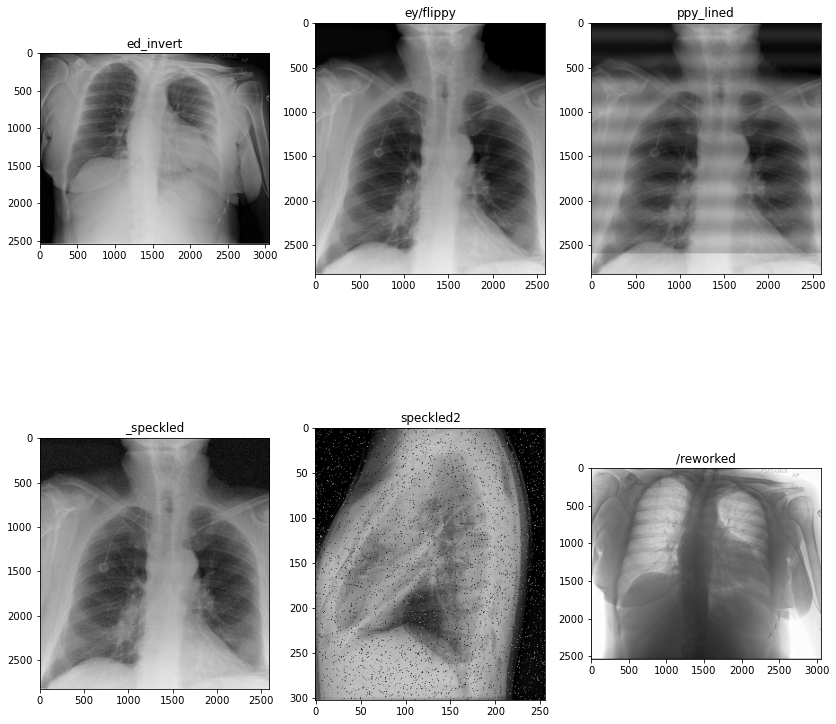

In [9]:
file_names_B = ['granny_cam/noisey/reworked_invert.jpg',
              'granny_cam/noisey/flippy.jpeg',
              'granny_cam/noisey/flippy_lined.jpeg',
              'granny_cam/noisey/flippy_speckled.jpeg',
              'granny_cam/noisey/speckled2.jpg',
              'granny_cam/noisey/reworked.jpg',
             ]
iwork.show_images_in_df(file_names_B,9)

### Let's see the segmentation going on inside the bling_segmented noise
As it would happen for each image

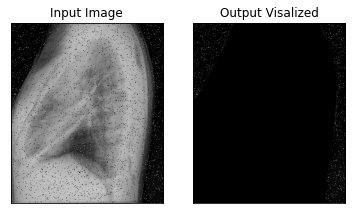

In [10]:
image = 'granny_cam/speckled2.jpg'
image_read = cv2.imread(image)
thresh = 20
blur_image = cv2.medianBlur(image_read, 7)
output_image = image_read.copy()
mask = blur_image < thresh
output_image[~mask] = 0
plt.subplot(121),plt.imshow(image_read, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(output_image, cmap = 'gray')
plt.title('Output Visalized'), plt.xticks([]), plt.yticks([])
plt.show()

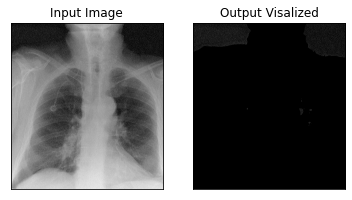

In [11]:
image = 'granny_cam/flippy_speckled.jpeg'
image_read = cv2.imread(image)
thresh = 20
blur_image = cv2.medianBlur(image_read, 7)
output_image = image_read.copy()
mask = blur_image < thresh
output_image[~mask] = 0
plt.subplot(121),plt.imshow(image_read, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(output_image[:,:,0], cmap = 'gray')
plt.title('Output Visalized'), plt.xticks([]), plt.yticks([])
plt.show()

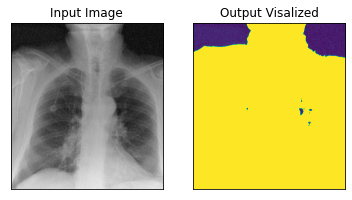

In [12]:
# let's take a closer look at the mask by putting it into a different color map
# remember the flat yellow area is our mask
image = 'granny_cam/flippy_speckled.jpeg'
image_read = cv2.imread(image)
thresh = 20
blur_image = cv2.medianBlur(image_read, 7)
output_image = image_read.copy()
mask = blur_image < thresh
output_image[~mask] = 255
plt.subplot(121),plt.imshow(image_read[:,:,0], cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(output_image[:,:,0], cmap = 'viridis')
plt.title('Output Visalized'), plt.xticks([]), plt.yticks([])
plt.show()

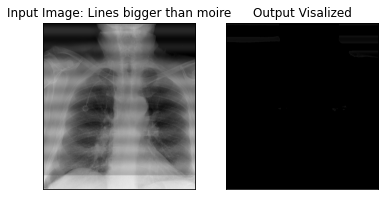

In [13]:
image = 'granny_cam/flippy_lined.jpeg'
image_read = cv2.imread(image)
thresh = 20
blur_image = cv2.medianBlur(image_read, 7)
output_image = image_read.copy()
mask = blur_image < thresh
output_image[~mask] = 0
plt.subplot(121),plt.imshow(image_read, cmap = 'gray')
plt.title('Input Image: Lines bigger than moire'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(output_image, cmap = 'gray')
plt.title('Output Visalized'), plt.xticks([]), plt.yticks([])
plt.show()
# plt.subplot(123),plt.imshow(output_image)#, cmap)
# plt.title('Output Visalized'), plt.xticks([]), plt.yticks([])
# plt.show()

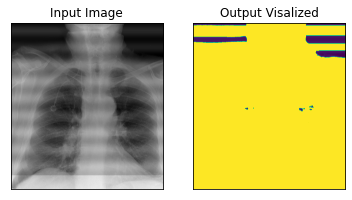

In [14]:
# let's take a closer look at the mask by putting it into a different color map
# remember the flat yellow area is our mask
image = 'granny_cam/flippy_lined.jpeg'
image_read = cv2.imread(image)
thresh = 20
blur_image = cv2.medianBlur(image_read, 7)
output_image = image_read.copy()
mask = blur_image < thresh
output_image[~mask] = 255
plt.subplot(121),plt.imshow(image_read[:,:,0], cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(output_image[:,:,0], cmap = 'viridis')
plt.title('Output Visalized'), plt.xticks([]), plt.yticks([])
plt.show()

Right above here, we have an image with a particular line pattern with lines much fatter than a typical aliasing/moiré effect. The segmentation of the segmented_background_noise image only picks up the darkest areas, avoiding most of our noise (the lines). We masked over most of one type of noise! In reality, this will not happen for most moiré patterns, but thick stripes are currently (24/01/2022) a problem for the segmened_blind_noise_matrix algorithm. Suppose you want to get very sophisticated at finding lines and moiré patterns. In that case, it is recommended to work on the Fourier transformed images (not covered deeply in this notebook, but see what happens if you swap in a lined image on the Fourier algorithms...) 

### Back to the big picture: we see a simple mask based on blurring mostly picks up our background but might also pick up tiny bits of blackish area. We also see that it will not pick up the whole background (flippy_lined image). The algorithm reads the noise for the entire image, however as most of the image is masked with zeros, there is no noise.

The segmented_blind_noise_matrix takes the locations it interprets as background, then sums noise by specific algorithms inside the function, and divides by that physical noise area of these locations. Note that there is not a black background on some images, so there will be nothing to interpret. We will end up with numbers that make no sense. Let's look at our fluoro-like image

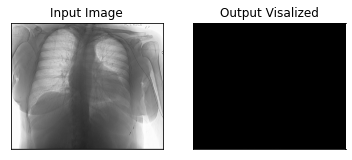

In [15]:
image = 'granny_cam/reworked.jpg'
image_read = cv2.imread(image)
thresh = 20
blur_image = cv2.medianBlur(image_read, 7)
output_image = image_read.copy()
mask = blur_image < thresh
output_image[~mask] = 0
plt.subplot(121),plt.imshow(image_read, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(output_image, cmap = 'gray')
plt.title('Output Visalized'), plt.xticks([]), plt.yticks([])
plt.show()

### OK, let's look at our two noise matrices

In [16]:
directory1 = 'granny_cam/noisey'
iwork.blind_noise_matrix(directory1)

,name_image,noise_non_local_mean,noise_gaussian,noise_3_k_median,noise_5_k_median,noise_7_k_median,noise_bilat_large,noise_bilat_small
0,granny_cam/noisey\reworked.jpg,74.410346,16.574229,18.160936,38.076059,53.704779,83.817667,119.254461
1,granny_cam/noisey\reworked_invert.jpg,75.370922,16.608936,18.190318,38.042178,53.666647,81.694960,121.731806
2,granny_cam/noisey\speckled2.jpg,4.952841,117.471934,73.297765,92.012428,100.271181,136.708050,112.174466
3,granny_cam/noisey\flippy.jpeg,76.804448,24.319987,26.445200,45.951231,59.875970,82.856623,114.588407
4,granny_cam/noisey\flippy_lined.jpeg,72.149141,22.720214,27.262847,43.626813,55.383525,78.148198,122.324863
5,granny_cam/noisey\flippy_speckled.jpeg,1.516969,50.353818,35.335564,48.504383,58.676877,41.485176,112.710950


In [17]:
iwork.segmented_blind_noise_matrix(directory1)

,name_image,noise_non_local_mean,noise_gaussian,noise_3_k_median,noise_5_k_median,noise_7_k_median,noise_bilat_large,noise_bilat_small
0,granny_cam/noisey\reworked.jpg,0.180306,0.111495,0.099649,0.133098,0.143590,0.171185,0.184584
1,granny_cam/noisey\reworked_invert.jpg,2.600113,0.604289,0.602180,1.094466,1.603717,2.788935,8.593235
2,granny_cam/noisey\speckled2.jpg,0.987213,7.103465,7.133090,8.012972,8.663924,6.111275,13.910709
3,granny_cam/noisey\flippy.jpeg,1.882925,0.540278,0.391460,0.691914,1.108372,1.965910,3.475662
4,granny_cam/noisey\flippy_lined.jpeg,1.644899,0.484601,0.195218,0.352339,0.718294,2.225965,4.441095
5,granny_cam/noisey\flippy_speckled.jpeg,0.027368,3.572957,1.939906,2.142168,2.411596,3.197526,6.702076


Notice it gave us numbers for the reworked image (which has a white background). How? It found a small area of black. We can see it if we look at the array

In [18]:
image_read

array([[[  1,   1,   1],
        [  0,   0,   0],
        [ 18,  18,  18],
        ...,
        [149, 149, 149],
        [149, 149, 149],
        [149, 149, 149]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [ 18,  18,  18],
        ...,
        [159, 159, 159],
        [159, 159, 159],
        [159, 159, 159]],

       [[  4,   4,   4],
        [  1,   1,   1],
        [ 25,  25,  25],
        ...,
        [202, 202, 202],
        [202, 202, 202],
        [202, 202, 202]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [ 17,  17,  17],
        ...,
        [ 96,  96,  96],
        [ 96,  96,  96],
        [ 96,  96,  96]],

       [[  2,   2,   2],
        [  0,   0,   0],
        [  9,   9,   9],
        ...,
        [ 20,  20,  20],
        [ 20,  20,  20],
        [ 20,  20,  20]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  4,   4,   4],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

The first line of pixels from the top will be read as background. But we should expect all the numbers we got from the algorithm to be worthless.

### It is imperative to think about how the noise detection algorithm works before interpreting the results. It is recommended to only segmented_blind_noise_matrix only on images with a black background, and perhaps only on standing (not supine) images.

Also note, when we limit ourselves to background (which is preferable if we can) by every algorithm except non-local means our original image flippy from which noisy images were made is interpreted as a lower noise image than its derived speckled noisy counterparts...